# Unsupervised Methods

In [96]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import multiprocessing
from sklearn.cluster import KMeans
from scipy.sparse import dok_matrix


## Trying to use Word2Vec

Confused on this for now, there is a "manual" method below.

In [97]:
cores = multiprocessing.cpu_count()

In [98]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=1000,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [99]:
data = pd.read_csv('../data/labeled_phrases.csv')
data.head()

,phrase_id,phrase_tokens,sentiment_values
0,3,cockettes,0.50000
1,4,cockettes,0.42708
2,5,cockettes provide window subculture hell bent ...,0.37500
3,6,cockettes provide window subculture hell bent ...,0.41667
4,7,cockettes provide window subculture hell bent ...,0.54167


In [100]:
data['phrase_lists'] = data['phrase_tokens'].apply(lambda x: x.split())

In [101]:
w2v_model.build_vocab(data['phrase_lists'], progress_per=10000)

In [102]:
w2v_model.train(data['phrase_lists'], total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(2851706, 5149095)

In [103]:
wordvecs = w2v_model.wv

In [104]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(wordvecs.vectors)

In [105]:
wordvecs.similar_by_vector(kmeans.cluster_centers_[1], topn=20)

[('secret', 0.9981810450553894),
 ('ya', 0.9906198382377625),
 ('divine', 0.988797664642334),
 ('sisterhood', 0.9845513105392456),
 ('ballot', 0.8973380327224731),
 ('la', 0.8739661574363708),
 ('essence', 0.8454127311706543),
 ('chamber', 0.8380852937698364),
 ('iranian', 0.8174875378608704),
 ('bury', 0.7982103824615479),
 ('defiantly', 0.795210599899292),
 ('terrific', 0.791651725769043),
 ('broadway', 0.7745000123977661),
 ('task', 0.7499709129333496),
 ('bonding', 0.7471630573272705),
 ('exactly', 0.746494710445404),
 ('communal', 0.7421152591705322),
 ('agent', 0.7383773326873779),
 ('definitely', 0.7375342845916748),
 ('potter', 0.733981728553772)]

In [107]:
vocab = list(set(data['phrase_tokens'].str.cat(sep=' ').split()))
word2id = {vocab[x] :x for x in range(len(vocab))}

In [221]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

## Manual Method not using Word2Vec

In [109]:
def convert_to_matrix(data, word2id):
    mat_size = len(data),len(word2id)+1
    oov_index = len(word2id)
    
    X = dok_matrix(mat_size)
    
    for doc_id, doc in enumerate(list(data['phrase_tokens'])):
        for word in doc.split():
            X[doc_id,word2id.get(word, oov_index)] += 1
    
    return X

X = convert_to_matrix(data, word2id)

In [112]:
k = KMeans(n_clusters=2)

In [113]:
k.fit(X)

KMeans(n_clusters=2)

In [133]:
for x in np.argsort(k.cluster_centers_[1])[-20:]:
    print(vocab[x])

action
star
character
year
much
no
well
feel
film
see
go
time
good
bad
like
not
one
n
make
movie


In [132]:
for x in np.argsort(k.cluster_centers_[0])[-20:]:
    print(vocab[x])

even
way
work
get
see
much
life
well
no
comedy
time
good
character
story
like
one
not
make
n
film


In [202]:
sentiment_simple = data['sentiment_values'] < 0.5

In [203]:
sentiment_simple = sentiment_simple.astype(int)

In [204]:
np.unique(sentiment_simple, return_counts=True)

(array([0, 1]), array([149846,  87598]))

In [205]:
np.unique(k.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([225498,  11946]))

In [222]:
scores = np.unique(k.labels_ == sentiment_simple, return_counts=True)

In [227]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

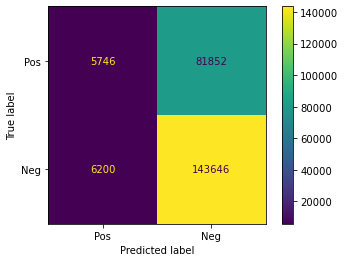

In [218]:
y_true = sentiment_simple
y_preds = k.labels_
cm = confusion_matrix(y_true, y_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(cm, display_labels=['Pos', 'Neg'])
disp.plot()

In [226]:
scores[1][1] / sum(scores[1])

0.6291672983945689

In [232]:
f1_score(y_true, y_preds, average='weighted')

0.5256249194008634